<a href="https://colab.research.google.com/github/tomoyok/Test-Fin-Tech-Case/blob/main/Falcon_TST_FX_Quantile_Forecasting_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 案例12 Falcon‑TST (Ant International × Citi) — FX Forecasting,jupyter notebook实现

此notebook尝试复现Falcon‑TST关键设计（因 Falcon‑TST 为闭源模型）。根据公开的信息可知，目前核心部分有：

1) 多源数据融合与特征工程（历史行情 + 跨品种联动 + 波动率Term/Skew/"IV"近似）
2) 大规模 Transformer 时序架构，直接输出多视角分位数区间（Quantile Forecast）
3) 端到端业务闭环：以区间预测驱动的风控/交易策略回测（含交易成本）

In [1]:
# -------------------------------------------------------------
# @title 0. 环境初始化
# @desc：
# 依赖：yfinance, numpy, pandas, scikit-learn, torch, matplotlib, tqdm, ta
# -------------------------------------------------------------

!pip -q install --upgrade-strategy only-if-needed yfinance ta numpy pandas scikit-learn torch matplotlib tqdm

  Preparing metadata (setup.py) ... done


In [2]:
# -------------------------------------------------------------
#@title 1. 全局参数区
# -------------------------------------------------------------

import math
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

CONFIG = {
    "target_fx": "EURUSD=X",            # 预测标的
    "exog_fx": [                         # 作为外生协变量的其他主要外汇品种
        "GBPUSD=X", "USDJPY=X", "AUDUSD=X", "USDCNH=X"
    ],
    "start": "2010-01-01",
    "end": None,                          # None=今天
    "seq_len": 64,                        # Transformer 输入序列长度
    "horizons": [1, 5, 22],               # 预测视角：1日/5日/22日累计收益
    "quantiles": [0.05, 0.5, 0.95],       # 分位数输出
    "batch_size": 128,
    "epochs": 12,                         # 演示训练轮数，可加大
    "d_model": 128,
    "nhead": 8,
    "num_layers": 3,
    "ffn_dim": 256,
    "dropout": 0.1,
    "lr": 1e-3,
    "weight_decay": 1e-5,
    "transaction_cost_bps": 5,            # 回测成本（单边，基点）
    "test_ratio": 0.2,                    # 测试集比例
    "val_ratio": 0.1,                     # 验证集比例（相对训练集）
    "seed": 42,
}

np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])

In [3]:
# ==============================
# @title * . 数据上传（CSV / yfinace）
# @desc:此处用mockdata体验
# ==============================
from google.colab import files
import pandas as pd

uploaded = files.upload()  # 选择prices.csv上传
test_prices = pd.read_csv("mock_fx_prices.csv")
print(test_prices.head())

Saving mock_fx_prices.csv to mock_fx_prices.csv
         Date  EURUSD=X  GBPUSD=X    USDJPY=X  AUDUSD=X  USDCNH=X
0  2010-01-01  1.100000  1.300000  110.000000  0.750000  6.533368
1  2010-01-04  1.098541  1.307161  110.515021  0.748166  6.542447
2  2010-01-05  1.095658  1.301800  110.852819  0.738460  6.514261
3  2010-01-06  1.092171  1.292904  111.304915  0.732063  6.490106
4  2010-01-07  1.101284  1.300690  110.913293  0.732045  6.484430


In [5]:
# -------------------------------------------------------------
# @title 2A. 数据准备
# -------------------------------------------------------------
import os
import numpy as np
import pandas as pd
import yfinance as yf

# ---- 可调参数 ----
SYMBOLS = [CONFIG["target_fx"], *CONFIG["exog_fx"]]
START = CONFIG["start"]
END = CONFIG["end"]  # None 表示到今天
PRICE_CSV = "mock_fx_prices.csv"   # 你也可以换成自己的CSV路径

def _generate_mock_prices(symbols, start, end):
    """合成一份带相关结构的外汇价格，作为兜底"""
    dates = pd.bdate_range(start or "2010-01-01", end or pd.Timestamp.today().date())
    d = len(symbols); n = len(dates)
    # 大致年化波动（可改）
    ann_vols_map = {
        "EURUSD=X": 0.09, "GBPUSD=X": 0.10, "USDJPY=X": 0.11, "AUDUSD=X": 0.12, "USDCNH=X": 0.04
    }
    ann_vols = np.array([ann_vols_map.get(s, 0.08) for s in symbols])
    daily_sigmas = ann_vols / np.sqrt(252)
    # 相关矩阵（粗略）
    corr = np.eye(d)
    for i in range(d):
        for j in range(d):
            if i==j: continue
            si, sj = symbols[i], symbols[j]
            v = 0.3
            if ("USDJPY" in si) ^ ("USDJPY" in sj): v = -0.3
            if ("EURUSD" in si and "GBPUSD" in sj) or ("GBPUSD" in si and "EURUSD" in sj): v = 0.7
            corr[i, j] = v
    cov = np.outer(daily_sigmas, daily_sigmas) * corr
    L = np.linalg.cholesky(cov)
    np.random.seed(CONFIG["seed"])
    Z = np.random.normal(size=(n, d))
    eps = Z @ L.T
    daily_mu = np.zeros(d)  # 年化漂移设为 0 简化
    rets = (daily_mu/252.0) + eps

    # 初始价（粗略设定）
    starts_map = {"EURUSD=X":1.1, "GBPUSD=X":1.30, "USDJPY=X":110.0, "AUDUSD=X":0.75, "USDCNH=X":6.80}
    starts = np.array([starts_map.get(s, 1.0) for s in symbols])

    prices = np.zeros((n, d))
    prices[0] = starts
    for t in range(1, n):
        prices[t] = prices[t-1] * np.exp(rets[t])

    px = pd.DataFrame(prices, index=dates, columns=symbols)
    # 给 CNH 一点缓慢趋势（非必须）
    if any("USDCNH" in s for s in symbols):
        trend = np.linspace(0.0, 0.08, n)
        cnh_cols = [c for c in symbols if "USDCNH" in c]
        for c in cnh_cols:
            px[c] = px[c] * np.exp(trend - trend.mean())
    return px

def get_prices(symbols, start, end, csv_path=None):
    # 1) 尝试读取本地/上传 CSV
    if csv_path and os.path.exists(csv_path):
        px = pd.read_csv(csv_path, parse_dates=["Date"], index_col="Date")
        # 只保留请求的列，并按时间范围裁剪
        cols = [s for s in symbols if s in px.columns]
        px = px[cols].loc[start:end].sort_index().ffill().dropna()
        if len(px) > 0:
            print(f"[INFO] 读取 CSV 成功: {csv_path} -> shape={px.shape}")
            return px

    # 2) 在线抓取
    try:
        data = yf.download(symbols, start=start, end=end, auto_adjust=True, progress=False)
        if isinstance(symbols, str):
            px = data[["Close"]].rename(columns={"Close": symbols})
        else:
            px = data["Close"]
        px = px.sort_index().ffill().dropna(how="all")
        # 部分列可能缺失或全空：只保留非空列
        px = px.dropna(axis=1, how="all")
        cols = [c for c in symbols if c in px.columns]
        px = px[cols]
        if len(px) > 0 and px.shape[1] > 0:
            print(f"[INFO] yfinance 获取成功 -> shape={px.shape}")
            return px
        else:
            print("[WARN] yfinance 获取为空，进入 mock 兜底")
    except Exception as e:
        print(f"[WARN] yfinance 异常：{e}，进入 mock 兜底")

    # 3) 兜底：合成 mock
    px = _generate_mock_prices(symbols, start, end)
    print('[INFO] 生成 mock 价格 -> shape={', px.shape, '}')
    return px

# === 执行，产出 px ===
px = get_prices(SYMBOLS, START, END, csv_path=PRICE_CSV)
display(px.head())
print("px 形状:", px.shape, "日期范围:", px.index.min(), "->", px.index.max(), "列:", list(px.columns))

[INFO] 读取 CSV 成功: mock_fx_prices.csv -> shape=(3914, 5)


,EURUSD=X,GBPUSD=X,USDJPY=X,AUDUSD=X,USDCNH=X
Date,,,,,
2010-01-01,1.100000,1.300000,110.000000,0.750000,6.533368
2010-01-04,1.098541,1.307161,110.515021,0.748166,6.542447
2010-01-05,1.095658,1.301800,110.852819,0.738460,6.514261
2010-01-06,1.092171,1.292904,111.304915,0.732063,6.490106
2010-01-07,1.101284,1.300690,110.913293,0.732045,6.484430


px 形状: (3914, 5) 日期范围: 2010-01-01 00:00:00 -> 2025-01-01 00:00:00 列: ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'AUDUSD=X', 'USDCNH=X']


In [6]:
# -------------------------------------------------------------
# @title 2B. 多源特征工程
# @input：px
# @output：全新feats，包含技术指标、统计特征和未来收益率标签
# -------------------------------------------------------------
import numpy as np
import pandas as pd
from ta.momentum import RSIIndicator
from ta.trend import MACD

def ewma_vol_series(returns: pd.Series, lam=0.94):
    arr = returns.values.copy()
    var = np.zeros_like(arr)
    finite = arr[~np.isnan(arr)]
    var[0] = np.var(finite) if len(finite) > 0 else 0.0
    for t in range(1, len(arr)):
        prev = 0 if np.isnan(arr[t-1]) else arr[t-1]**2
        var[t] = (1 - lam) * prev + lam * var[t-1]
    return pd.Series(np.sqrt(var), index=returns.index)

def make_fx_features_from_px(px: pd.DataFrame, config: dict) -> pd.DataFrame:
    assert isinstance(px, pd.DataFrame) and len(px) > 0, "px 为空，请先在 2A 成功生成 px"
    tgt = config["target_fx"]
    exog = [s for s in config["exog_fx"] if s in px.columns]
    if tgt not in px.columns:
        raise ValueError(f"目标品种 {tgt} 不在 px 列中：{list(px.columns)}")

    # 统一对齐、处理缺失
    px = px.sort_index().ffill().dropna()
    rets = np.log(px / px.shift(1))

    feats = pd.DataFrame(index=px.index)

    # 目标基础特征
    r = rets[tgt]
    feats[f"{tgt}_r1"] = r
    for w in [5, 22, 66, 132]:
        feats[f"{tgt}_rv_{w}"] = r.rolling(w).std() * np.sqrt(252)
    feats[f"{tgt}_term_s_m"] = feats[f"{tgt}_rv_{5}"] / feats[f"{tgt}_rv_{22}"]
    feats[f"{tgt}_term_m_l"] = feats[f"{tgt}_rv_{22}"] / feats[f"{tgt}_rv_{66}"]
    feats[f"{tgt}_skew_22"] = r.rolling(22).skew()

    # “IV”代理：EWMA
    feats[f"{tgt}_iv94"] = ewma_vol_series(r, 0.94) * np.sqrt(252)
    feats[f"{tgt}_iv97"] = ewma_vol_series(r, 0.97) * np.sqrt(252)

    # 技术指标（用目标的价格）
    rsi = RSIIndicator(close=px[tgt], window=14).rsi()
    macd = MACD(close=px[tgt])
    feats[f"{tgt}_rsi14"] = rsi
    feats[f"{tgt}_macd"] = macd.macd()
    feats[f"{tgt}_macd_sig"] = macd.macd_signal()

    # 跨品种联动
    for sym in exog:
        rr = rets[sym]
        feats[f"{sym}_r1"]   = rr
        feats[f"{sym}_rv22"] = rr.rolling(22).std() * np.sqrt(252)
        feats[f"{sym}_cor22"] = rr.rolling(22).corr(r)

    # 日历/季节性
    dow = px.index.dayofweek
    feats["dow_sin"] = np.sin(2*np.pi*dow/7)
    feats["dow_cos"] = np.cos(2*np.pi*dow/7)
    month = px.index.month
    feats["mon_sin"] = np.sin(2*np.pi*month/12)
    feats["mon_cos"] = np.cos(2*np.pi*month/12)

    # 预测标签
    for h in config["horizons"]:
        feats[f"y_h{h}"] = r.rolling(h).sum().shift(-h)

    feats = feats.replace([np.inf, -np.inf], np.nan).dropna()
    print("[INFO] 特征已生成 ->", feats.shape)
    return feats

# === 执行，产出 feats ===
feats = make_fx_features_from_px(px, CONFIG)
display(feats.tail())

[INFO] 特征已生成 -> (3760, 32)


,EURUSD=X_r1,EURUSD=X_rv_5,EURUSD=X_rv_22,EURUSD=X_rv_66,EURUSD=X_rv_132,EURUSD=X_term_s_m,EURUSD=X_term_m_l,EURUSD=X_skew_22,EURUSD=X_iv94,EURUSD=X_iv97,...,USDCNH=X_r1,USDCNH=X_rv22,USDCNH=X_cor22,dow_sin,dow_cos,mon_sin,mon_cos,y_h1,y_h5,y_h22
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-26,-0.002570,0.105940,0.109318,0.102023,0.094542,0.969098,1.071508,-0.466211,0.113280,0.105193,...,-0.003978,0.046820,0.050050,0.781831,0.623490,-5.000000e-01,0.866025,0.011190,0.014179,0.023444
2024-11-27,0.011190,0.130541,0.115854,0.104474,0.095739,1.126767,1.108934,-0.388485,0.110283,0.103844,...,-0.000848,0.044732,0.010253,0.974928,-0.222521,-5.000000e-01,0.866025,0.003812,0.013311,0.016699
2024-11-28,0.003812,0.098408,0.114533,0.104658,0.095260,0.859210,1.094357,-0.564462,0.115438,0.106802,...,-0.000211,0.044712,0.003078,0.433884,-0.900969,-5.000000e-01,0.866025,0.002940,0.003674,0.004097
2024-11-29,0.002940,0.092602,0.114437,0.103322,0.095040,0.809192,1.107577,-0.661289,0.112898,0.105709,...,-0.001233,0.044137,0.011664,-0.433884,-0.900969,-5.000000e-01,0.866025,-0.001840,0.000505,-0.003184
2024-12-02,-0.001840,0.087583,0.114783,0.102323,0.095045,0.763035,1.121774,-0.592626,0.110054,0.104425,...,0.003047,0.045206,-0.010003,0.000000,1.000000,-2.449294e-16,1.000000,-0.001923,-0.008087,0.005076


In [7]:
# -------------------------------------------------------------
#@title 3. 数据集切分 + 归一化 + 滑窗采样
class SeqDataset(Dataset):
    def __init__(self, X, Y, seq_len):
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        xseq = self.X[idx:idx+self.seq_len]
        y = self.Y[idx+self.seq_len-1]  # 使用序列末尾时点的标签（对应未来收益）
        return xseq, y

def train_val_test_split(df, test_ratio=0.2, val_ratio=0.1):
    n = len(df)
    n_test = int(n * test_ratio)
    n_trainval = n - n_test
    n_val = int(n_trainval * val_ratio)
    n_train = n_trainval - n_val
    return n_train, n_val, n_test

# 构造 X/Y
label_cols = [f"y_h{h}" for h in CONFIG["horizons"]]
X_df = feats.drop(columns=label_cols)
Y_df = feats[label_cols]

n_train, n_val, n_test = train_val_test_split(feats, CONFIG["test_ratio"], CONFIG["val_ratio"])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_df.iloc[:n_train])
X_val = scaler.transform(X_df.iloc[n_train:n_train+n_val])
X_test = scaler.transform(X_df.iloc[n_train+n_val:])

Y_train = Y_df.iloc[:n_train].values
Y_val = Y_df.iloc[n_train:n_train+n_val].values
Y_test = Y_df.iloc[n_train+n_val:].values

train_ds = SeqDataset(X_train, Y_train, CONFIG["seq_len"])
val_ds   = SeqDataset(X_val,   Y_val,   CONFIG["seq_len"])
test_ds  = SeqDataset(X_test,  Y_test,  CONFIG["seq_len"])

train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=CONFIG["batch_size"], shuffle=False, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=CONFIG["batch_size"], shuffle=False, drop_last=False)

print("Train/Val/Test 样本(滑窗后):", len(train_ds), len(val_ds), len(test_ds))

Train/Val/Test 样本(滑窗后): 2644 236 688


In [9]:
# -------------------------------------------------------------
#@title 4~5. Transformer（TST）分位数回归模型及训练
# -------------------------------------------------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TSTQuantile(nn.Module):
    def __init__(self, n_features, d_model, nhead, num_layers, ffn_dim, dropout, seq_len, n_horizons, n_quantiles):
        super().__init__()
        self.proj = nn.Linear(n_features, d_model)
        self.pos = PositionalEncoding(d_model, max_len=seq_len+5)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=ffn_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, n_horizons * n_quantiles)
        )
        self.n_h = n_horizons
        self.n_q = n_quantiles

    def forward(self, x):  # x: (B, T, F)
        z = self.proj(x)
        z = self.pos(z)
        z = self.encoder(z)
        # 聚合：取最后时点 + 平均池化（混合表征）
        last = z[:, -1, :]
        meanp = z.mean(dim=1)
        h = 0.5*last + 0.5*meanp
        out = self.head(h)
        return out.view(-1, self.n_h, self.n_q)

def quantile_loss(y_pred, y_true, quantiles):
    # y_pred: (B, H, Q), y_true: (B, H)
    loss = 0
    for i, q in enumerate(quantiles):
        e = y_true - y_pred[:, :, i]
        loss_q = torch.maximum((q-1)*e, q*e).mean()
        loss += loss_q
    return loss / len(quantiles)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TSTQuantile(
    n_features=X_train.shape[1],
    d_model=CONFIG["d_model"],
    nhead=CONFIG["nhead"],
    num_layers=CONFIG["num_layers"],
    ffn_dim=CONFIG["ffn_dim"],
    dropout=CONFIG["dropout"],
    seq_len=CONFIG["seq_len"],
    n_horizons=len(CONFIG["horizons"]),
    n_quantiles=len(CONFIG["quantiles"]),
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=CONFIG["weight_decay"])

# 训练
best_val = 1e9
for epoch in range(1, CONFIG["epochs"]+1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        yp = model(xb)
        loss = quantile_loss(yp, yb, CONFIG["quantiles"])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_losses = []
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            yp = model(xb)
            val_losses.append(quantile_loss(yp, yb, CONFIG["quantiles"]).item())
    val_m = np.mean(val_losses) if len(val_losses)>0 else np.mean(train_losses)
    print(f"Epoch {epoch:02d} | Train {np.mean(train_losses):.5f} | Val {val_m:.5f}")
    if val_m < best_val:
        best_val = val_m
        torch.save(model.state_dict(), "best_falcon_tst_fx.pt")

Epoch 01 | Train 0.08303 | Val 0.03196
Epoch 02 | Train 0.04162 | Val 0.02336
Epoch 03 | Train 0.03537 | Val 0.01551
Epoch 04 | Train 0.03040 | Val 0.01226
Epoch 05 | Train 0.02509 | Val 0.01161
Epoch 06 | Train 0.01851 | Val 0.00860
Epoch 07 | Train 0.01224 | Val 0.00914
Epoch 08 | Train 0.00838 | Val 0.00547
Epoch 09 | Train 0.00611 | Val 0.00492
Epoch 10 | Train 0.00521 | Val 0.00521
Epoch 11 | Train 0.00463 | Val 0.00496
Epoch 12 | Train 0.00436 | Val 0.00463


In [10]:
# -------------------------------------------------------------
#@title 6. 测试集推断 + 区间覆盖率 & 校准
# -------------------------------------------------------------

model.load_state_dict(torch.load("best_falcon_tst_fx.pt", map_location=device))
model.eval()

all_preds = []
all_trues = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yp = model(xb).cpu().numpy()  # (B, H, Q)
        all_preds.append(yp)
        all_trues.append(yb.numpy())

preds = np.concatenate(all_preds, axis=0)
trues = np.concatenate(all_trues, axis=0)

# 评估：中位数偏差 & 区间覆盖率
q_low_idx, q_med_idx, q_hi_idx = 0, 1, 2
res_table = []
for h_i, h in enumerate(CONFIG["horizons"]):
    y = trues[:, h_i]
    ql = preds[:, h_i, q_low_idx]
    qm = preds[:, h_i, q_med_idx]
    qh = preds[:, h_i, q_hi_idx]
    mae_med = np.mean(np.abs(y - qm))
    cover = np.mean((y>=ql) & (y<=qh))
    res_table.append({"horizon":h, "MAE@median": mae_med, "interval_coverage": cover})

print("\n区间覆盖/中位数误差 (测试集)：")
for r in res_table:
    print(r)


区间覆盖/中位数误差 (测试集)：
{'horizon': 1, 'MAE@median': np.float32(0.004777542), 'interval_coverage': np.float64(0.8357558139534884)}
{'horizon': 5, 'MAE@median': np.float32(0.01211658), 'interval_coverage': np.float64(0.9229651162790697)}
{'horizon': 22, 'MAE@median': np.float32(0.019106813), 'interval_coverage': np.float64(0.9854651162790697)}



回测指标(1日视角)：Sharpe=0.00, HitRatio=0.00, CAGR=0.00%
[DEBUG] 对齐长度：time=688, nav=688, ret=688, ds_len=688


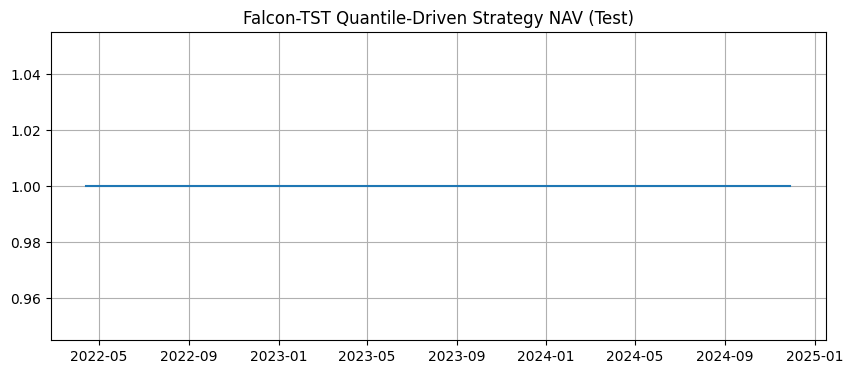

In [12]:
# -------------------------------------------------------------
#@title 7. 基于分位数信号的风控/交易回测（闭环）
# -------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# 0) 取 1 日视角的分位数
h_i = 0  # 0->1日, 1->5日, 2->22日
q_low_idx, q_med_idx, q_hi_idx = 0, 1, 2
ql = preds[:, h_i, q_low_idx]
qh = preds[:, h_i, q_hi_idx]

# 1) 生成仓位（简单门限）
pos = np.where(ql > 0, 1, np.where(qh < 0, -1, 0))

# 2) 真实未来收益（与 preds 对齐）
true_next_1d = trues[:, h_i]

# 3) 交易成本与收益
cost = CONFIG["transaction_cost_bps"] / 10000.0
turnover = np.abs(np.diff(np.r_[0, pos]))
ret = pos * true_next_1d - cost * turnover
nav = (1 + ret).cumprod()

# 4) —— 关键：构造与 ret/nav“严格对齐”的测试集时间索引 ——
# 全数据行数 = len(feats)
# 切分段：
#   训练: [0, n_train-1]
#   验证: [n_train, n_train+n_val-1]
#   测试: [n_train+n_val, n_train+n_val+n_test-1]
# 对于滑窗样本 idx∈[0, n_test-seq_len-1]，标签时间位置是：
#   global_pos = (n_train+n_val) + (idx + seq_len - 1)
start_block = n_train + n_val
end_block   = n_train + n_val + n_test                  # 右开
start_pos   = start_block + CONFIG["seq_len"] - 1       # 含
end_pos_ex  = end_block - 1                             # 含的最后一个应为 n_test-2 -> 用右开要+0
# pandas 索引用右开区间：长度应为 n_test - seq_len
idx_all = X_df.index
test_index = idx_all[start_pos:end_pos_ex]              # 注意：右开，不包含 end_pos_ex

# 容错：若仍有因边界造成的 1 个点误差，执行对齐修剪
m = min(len(test_index), len(nav))
test_index = test_index[-m:]
nav = nav[-m:]
ret = ret[-m:]
pos = pos[-m:]
true_next_1d = true_next_1d[-m:]

# 5) 绩效指标
sharpe = (np.mean(ret) / np.std(ret) * np.sqrt(252)) if np.std(ret) > 0 else 0.0
hit = np.mean((pos * true_next_1d) > 0)
cagr = (nav[-1] ** (252 / len(nav)) - 1) if len(nav) > 0 else 0.0
print(f"\n回测指标(1日视角)：Sharpe={sharpe:.2f}, HitRatio={hit:.2f}, CAGR={cagr:.2%}")
print(f"[DEBUG] 对齐长度：time={len(test_index)}, nav={len(nav)}, ret={len(ret)}, ds_len={len(test_ds)}")

# 6) 画净值曲线
plt.figure(figsize=(10, 4))
plt.plot(test_index, nav)
plt.title("Falcon-TST Quantile-Driven Strategy NAV (Test)")
plt.grid(True)
plt.show()